# Implementação de um algoritmo para fornecer explicações minimais
# para modelos de regressão logística para problemas de classificação
# multiclasse (one-versus-rest ou softmax).

A implementação do
algoritmo deve ser genérica para lidar com problemas com um número
arbitrário de features e de classes. Para ajudar, você pode olhar os
colabs disponibilizados nos materiais de aula. Além disso, o algoritmo
para explicação minimal está nas anotações do professor, também
disponibilizadas nos materiais de aula. O aluno também pode usar ferramentas de geração de código livremente.

Para testar seu código, um dos testes deve ser em um modelo treinado no conjundo de dados IRIS. Um outro teste deverá ser realizado por cada aluno conforme a lista a seguir:

Gleilson: modelo treinado no conjunto de dados MNIST apenas com classes 2, 4 e 7.

A explicação de uma instância do MNIST deve pintar de vermelho os pixels irrelevantes e deixar o pixel original para os pixels da explicação minimal.


In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from z3 import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from PIL import Image

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')
X_iris, y_iris = load_iris(return_X_y=True, as_frame=True)

In [3]:
scaler = MinMaxScaler()
scaler.fit(mnist.data)
scaler.set_output(transform='pandas')
data_scaled = scaler.transform(mnist.data)

scaler.fit(X_iris)
scaler.set_output(transform='pandas')
X_iris = scaler.transform(X_iris)

In [4]:
X, y = mnist.data, mnist.target
y = y.astype(np.uint8)

In [5]:
classes_to_keep = [2, 4, 7]
mask = np.isin(y, classes_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered)

In [7]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.3, stratify=y_iris)

In [8]:
logistic_regression_classifier = LogisticRegression(multi_class='multinomial', max_iter=200)
iris_class = LogisticRegression(multi_class='multinomial', max_iter=200)

In [9]:
logistic_regression_classifier.fit(X_train, y_train)
iris_class.fit(X_train_iris, y_train_iris)

c:\Users\gleilson.pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\gleilson.pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gleilson.pedro\AppData\Local\Programs

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'multinomial'


In [10]:
predictions = logistic_regression_classifier.predict(X_test)
predictions_iris = iris_class.predict(X_test_iris)

In [11]:
predictions_iris

array([1, 2, 1, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 2, 2, 0, 1,
       2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2,
       1])

In [12]:
accuracy = accuracy_score(y_test, predictions)
accuracy_iris = accuracy_score(y_test_iris, predictions_iris)
print("Mnist accuracy:", accuracy)
print("Iris accuracy:", accuracy_iris)

Mnist accuracy: 0.9573661771672193
Iris accuracy: 0.9555555555555556


In [13]:
def plot_mnist_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.show()

In [14]:
#global real_vars MNIST
real_vars = [Real('x_' + feature_name) for feature_name in X_filtered.columns]
domain_constraints_upper_bound = [x <= u for (x, u) in zip(real_vars, X_filtered.max())]
domain_constraints_lower_bound = [x >= l for (l, x) in zip(X_filtered.min(), real_vars)]
domain_constraints = domain_constraints_upper_bound + domain_constraints_lower_bound
logistic_reg1_term = logistic_regression_classifier.coef_[0] @ real_vars + logistic_regression_classifier.intercept_[0]
logistic_reg2_term = logistic_regression_classifier.coef_[1] @ real_vars + logistic_regression_classifier.intercept_[1]
logistic_reg3_term = logistic_regression_classifier.coef_[2] @ real_vars + logistic_regression_classifier.intercept_[2]

In [15]:
#global real_vars_iris
real_vars_iris = [Real('x_' + feature_name) for feature_name in X_iris.columns]
domain_constraints_upper_bound_iris = [x <= u for (x, u) in zip(real_vars_iris, X_iris.max())]
domain_constraints_lower_bound_iris = [x >= l for (l, x) in zip(X_iris.min(), real_vars_iris)]
domain_constraints_iris = domain_constraints_upper_bound_iris + domain_constraints_lower_bound_iris
logistic_reg1_term_iris = iris_class.coef_[0] @ real_vars_iris + iris_class.intercept_[0]
logistic_reg2_term_iris = iris_class.coef_[1] @ real_vars_iris + iris_class.intercept_[1]
logistic_reg3_term_iris = iris_class.coef_[2] @ real_vars_iris + iris_class.intercept_[2]

In [16]:
print(domain_constraints)
print(domain_constraints_iris)

[x_pixel1 <= 0, x_pixel2 <= 0, x_pixel3 <= 0, x_pixel4 <= 0, x_pixel5 <= 0, x_pixel6 <= 0, x_pixel7 <= 0, x_pixel8 <= 0, x_pixel9 <= 0, x_pixel10 <= 0, x_pixel11 <= 0, x_pixel12 <= 0, x_pixel13 <= 10, x_pixel14 <= 216, x_pixel15 <= 216, x_pixel16 <= 9, x_pixel17 <= 0, x_pixel18 <= 0, x_pixel19 <= 0, x_pixel20 <= 0, x_pixel21 <= 0, x_pixel22 <= 0, x_pixel23 <= 0, x_pixel24 <= 0, x_pixel25 <= 0, x_pixel26 <= 0, x_pixel27 <= 0, x_pixel28 <= 0, x_pixel29 <= 0, x_pixel30 <= 0, x_pixel31 <= 0, x_pixel32 <= 0, x_pixel33 <= 0, x_pixel34 <= 38, x_pixel35 <= 236, x_pixel36 <= 158, x_pixel37 <= 233, x_pixel38 <= 144, x_pixel39 <= 210, x_pixel40 <= 247, x_pixel41 <= 234, x_pixel42 <= 155, x_pixel43 <= 255, x_pixel44 <= 255, x_pixel45 <= 244, x_pixel46 <= 254, x_pixel47 <= 59, x_pixel48 <= 0, x_pixel49 <= 0, x_pixel50 <= 0, x_pixel51 <= 0, x_pixel52 <= 0, x_pixel53 <= 0, x_pixel54 <= 0, x_pixel55 <= 0, x_pixel56 <= 0, x_pixel57 <= 0, x_pixel58 <= 0, x_pixel59 <= 0, x_pixel60 <= 0, x_pixel61 <= 0, x

In [17]:
def encontrar_pixels_irrelevantes(imagem, modelo, classe_original):
    """
    Encontra os pixels mais sensíveis à mudança na predição do modelo.

    Args:
        imagem: A imagem como um array NumPy (28x28).
        modelo: O modelo de regressão logística.
        classe_original: A classe original prevista pelo modelo para a imagem.

    Returns:
        Uma lista com os índices dos pixels mais sensíveis.
    """

    # Calcular a predição original
    original_prediction = modelo.predict_proba(imagem.reshape(1, -1))[0]

    # Armazenar as diferenças de probabilidade e os índices dos pixels
    diffs = []

    # Iterar por cada pixel
    for i in range(imagem.size):
        # Criar uma cópia da imagem
        imagem_modificada = imagem.copy()

        # Mudar o valor do pixel para 0 ou 1
        imagem_modificada[i] = 1 if imagem_modificada[i] == 0 else 0

        # Calcular a nova predição
        nova_predição = modelo.predict_proba(imagem_modificada.reshape(1, -1))[0]

        # Calcular a diferença de probabilidade
        diff = abs(nova_predição[classe_original] - original_prediction[classe_original])

        # Armazenar a diferença e o índice do pixel
        diffs.append((diff, i))

    # Ordenar os pixels pela diferença de probabilidade
    diffs.sort(reverse=True)

    # Retornar os índices dos pixels mais sensíveis
    return [pixel_index for diff, pixel_index in diffs]


In [18]:
def minimalExplanation(I, D, P):
    E = [x == u for x, u in zip(real_vars, I)]
    solver = Solver()
    red_pixels = []
    for i in range(len(E) - 1, -1, -1):
        solver.reset()
        E_temp = E.copy()
        del E_temp[i]

        solver.add(E_temp)
        solver.add(D)
        solver.add(Not(P))
        if solver.check() != sat:
            E = E_temp.copy()
            red_pixels.append(i)


    return E, red_pixels


In [19]:
def minimalExplanationWithReturnInput(I, D, P):
    E = [x == u for x, u in zip(real_vars_iris, I)]
    print("Entrada original:", E)
    solver = Solver()
    for i in range(len(E) - 1, -1, -1):
        solver.reset()
        E_temp = E.copy()
        del E_temp[i]

        solver.add(E_temp)
        solver.add(D)
        solver.add(Not(P))
        if solver.check() != sat:
            E = E_temp.copy()

    return E


In [21]:
def pintar_pixels(imagem, deleted_pixels):
    if not isinstance(imagem, np.ndarray):
        imagem = np.array(imagem)

    if imagem.ndim == 2:
        imagem = imagem.flatten()

    imagem = imagem.astype(np.uint8)

    imagem = imagem.reshape(28, 28)

    imagem_rgb = Image.fromarray(imagem).convert("RGB")
    pixels = imagem_rgb.load()

    vermelho = (255, 0, 0)

    for index in deleted_pixels:
        x = index % 28
        y = index // 28
        pixels[x, y] = vermelho

    return imagem_rgb

In [22]:
for i in range(10):
    if(predictions_iris[i] == 0):
        formula = And(logistic_reg1_term_iris > logistic_reg2_term_iris, logistic_reg1_term_iris > logistic_reg3_term_iris)

    elif(predictions_iris[i] == 1):
        formula = And(logistic_reg2_term_iris > logistic_reg1_term_iris, logistic_reg2_term_iris > logistic_reg3_term_iris)

    else:
        formula = And(logistic_reg3_term_iris > logistic_reg1_term_iris, logistic_reg3_term_iris > logistic_reg2_term_iris)

    minexp = minimalExplanationWithReturnInput(X_test_iris.iloc[i], domain_constraints_iris, formula)
    print("\nExplicação minimal para a entrada {}\n".format(i), minexp)


Entrada original: [x_sepal length (cm) == 2499999999999999/5000000000000000, x_sepal width (cm) == 16666666666666663/50000000000000000, x_petal length (cm) == 635593220338983/1250000000000000, x_petal width (cm) == 5000000000000001/10000000000000000]

Explicação minimal para a entrada 0
 [x_sepal width (cm) == 16666666666666663/50000000000000000, x_petal length (cm) == 635593220338983/1250000000000000, x_petal width (cm) == 5000000000000001/10000000000000000]
Entrada original: [x_sepal length (cm) == 4722222222222221/5000000000000000, x_sepal width (cm) == 20833333333333337/50000000000000000, x_petal length (cm) == 8644067796610169/10000000000000000, x_petal width (cm) == 4583333333333333/5000000000000000]

Explicação minimal para a entrada 1
 [x_sepal length (cm) == 4722222222222221/5000000000000000, x_sepal width (cm) == 20833333333333337/50000000000000000, x_petal width (cm) == 4583333333333333/5000000000000000]
Entrada original: [x_sepal length (cm) == 16666666666666663/50000000000

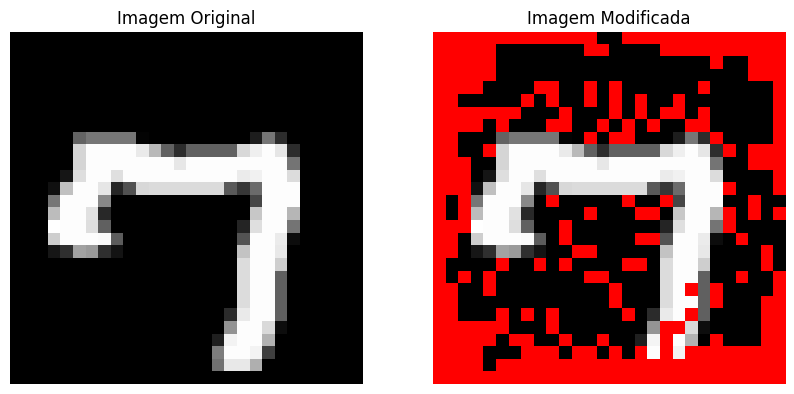

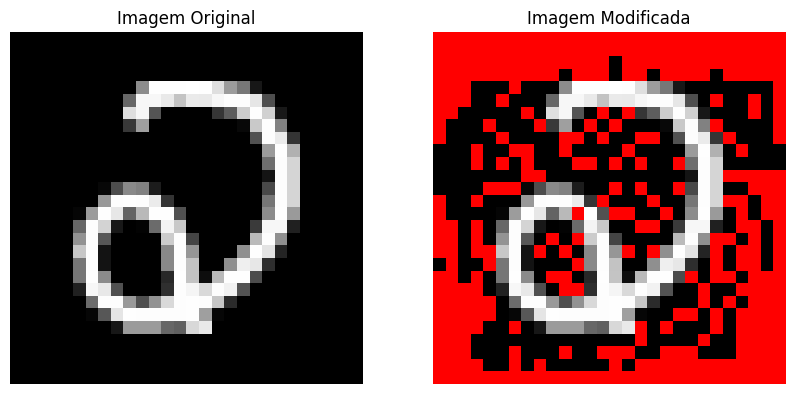

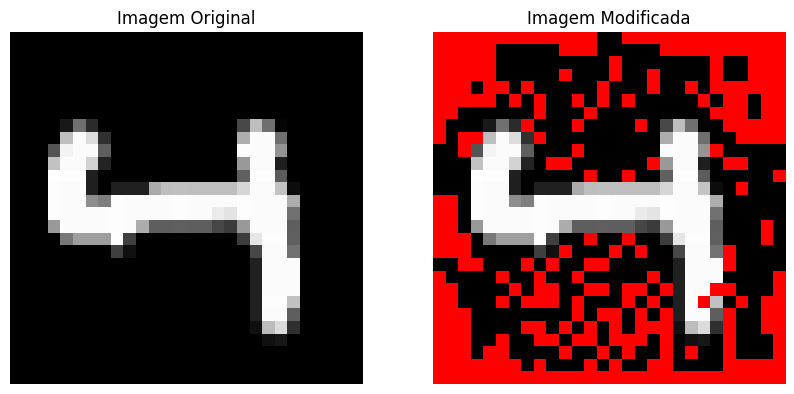

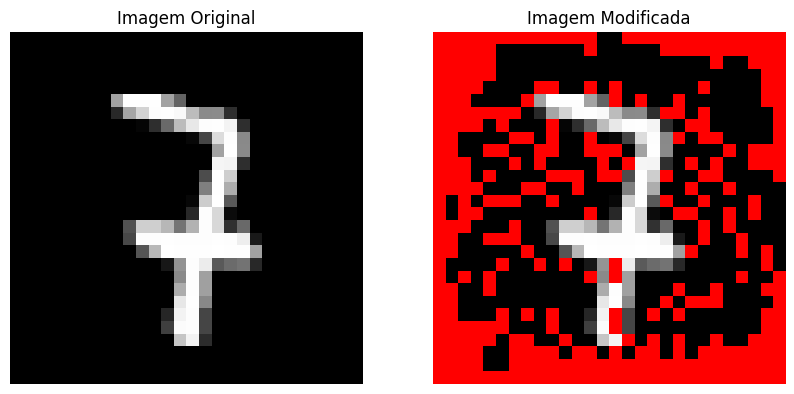

In [23]:
for i in range(4):
    if(predictions[i] == 2):
        formula = And(logistic_reg1_term > logistic_reg2_term, logistic_reg1_term > logistic_reg3_term)

    elif(predictions[i] == 4):
        formula = And(logistic_reg2_term > logistic_reg1_term, logistic_reg2_term > logistic_reg3_term)

    else:
        formula = And(logistic_reg3_term > logistic_reg1_term, logistic_reg3_term > logistic_reg2_term)

    img, red_pixel = minimalExplanation(X_test.iloc[i], domain_constraints, formula)

    img_rgb = pintar_pixels(X_test.iloc[i], red_pixel)
    # plot_mnist_image(np.array(X_test.iloc[i]))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(np.array(X_test.iloc[i]).reshape(28, 28), cmap='gray')
    axs[0].set_title('Imagem Original')
    axs[0].axis('off')


    axs[1].imshow(img_rgb)
    axs[1].set_title('Imagem Modificada')
    axs[1].axis('off')

    plt.show()
